In [ ]:
if (!require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

BiocManager::install(version = "3.19")
BiocManager::install("GenomicRanges")
BiocManager::install("igvR")
BiocManager::install("AnnotationHub")

In [ ]:
if (!require("arrow", quietly = TRUE))
  install.packages("arrow")

if (!require("tidyverse", quietly = TRUE))
  install.packages("tidyverse")

if (!require("ggsci", quietly = TRUE))
  install.packages("ggsci")

if (!require("ggalluvial", quietly = TRUE))
  install.packages("ggalluvial")

if (!require("ggedit", quietly = TRUE))
  install.packages("ggedit")  

if (!require("ggdist", quietly = TRUE))
  install.packages("ggdist")

In [ ]:
library(arrow)
library(tidyverse)
library(esquisse)
library(ggsci)
library(ggalluvial)
library(ggedit)
library(ggdist)

library(GenomicRanges)
library(rtracklayer)
library(AnnotationHub)
library(Biostrings)
library(igvR)

We generate a custom function that will return a continuous range of colours on our chosen palette: Futurama

In [3]:
futurama_unlimited_palette <- function(input_colour_number = 12, output_colour_number) {
  planet_express <- pal_futurama("planetexpress")(input_colour_number)
  output_colour <- colorRampPalette(planet_express)(output_colour_number)
  return (output_colour)
}

futurama_unlimited_palette(3, 100)

  [1] "#FF6F00" "#FD6D00" "#FC6B00" "#FB6900" "#FA6700" "#F96500" "#F86300"
  [8] "#F76100" "#F55F00" "#F45D00" "#F35B00" "#F25900" "#F15700" "#F05600"
 [15] "#EF5400" "#EE5200" "#EC5000" "#EB4E00" "#EA4C00" "#E94A00" "#E84800"
 [22] "#E74600" "#E64400" "#E44200" "#E34000" "#E23F00" "#E13D00" "#E03B00"
 [29] "#DF3900" "#DE3700" "#DD3500" "#DB3300" "#DA3100" "#D92F00" "#D82D00"
 [36] "#D72B00" "#D62900" "#D52700" "#D42600" "#D22400" "#D12200" "#D02000"
 [43] "#CF1E00" "#CE1C00" "#CD1A00" "#CC1800" "#CA1600" "#C91400" "#C81200"
 [50] "#C71000" "#C41101" "#C01304" "#BC1608" "#B8180B" "#B41B0E" "#B01E11"
 [57] "#AC2015" "#A82318" "#A4251B" "#A0281E" "#9C2A21" "#982D25" "#942F28"
 [64] "#90322B" "#8C342E" "#883732" "#843A35" "#803C38" "#7C3F3B" "#78413F"
 [71] "#744442" "#704645" "#6C4948" "#684B4B" "#644E4F" "#605052" "#5C5355"
 [78] "#585658" "#54585C" "#505B5F" "#4C5D62" "#486065" "#446269" "#40656C"
 [85] "#3C676F" "#386A72" "#346C75" "#306F79" "#2C727C" "#28747F" "#247782"
 [92] "#2079

We import our file in parquet format

In [4]:
data <- arrow::read_parquet(file.path('F:','Archive','Trabajo','Profesiones','Bioinformatica','PhD','Assignments','enERVate','results','tables','full_vs_ltr.parquet'))

And try to find the columns with the relevant data

In [5]:
colnames(data)

 [1] "family"              "virus"               "abbreviation"       
 [4] "species"             "probe"               "accession"          
 [7] "identifier"          "strand"              "genbank_id"         
[10] "genbank_name"        "genbank_description" "genbank_dbxrefs"    
[13] "genbank_annotations" "genbank_seq"         "alignment_title"    
[16] "alignment_length"    "alignment_accession" "alignment_hit_id"   
[19] "alignment_hit_def"   "hsp_bits"            "hsp_score"          
[22] "hsp_evalue"          "hsp_query"           "hsp_sbjct"          
[25] "hsp_query_start"     "hsp_query_end"       "hsp_sbjct_start"    
[28] "hsp_sbjct_end"       "hsp_identity"        "hsp_align_length"   
[31] "hsp_gaps"            "hsp_positives"       "hsp_strand"         
[34] "hsp_frame"          

In [6]:
head(data$alignment_hit_def)

[1] "CM040288.1 Desmodus rotundus isolate HL8 chromosome 1, whole genome shotgun sequence (dbseq-nr 0) [94813276,94828031]" 
[2] "CM040301.1 Desmodus rotundus isolate HL8 chromosome X, whole genome shotgun sequence (dbseq-nr 13) [54763184,54776945]"
[3] "CM040291.1 Desmodus rotundus isolate HL8 chromosome 4, whole genome shotgun sequence (dbseq-nr 3) [74997901,75009721]" 
[4] "CM040288.1 Desmodus rotundus isolate HL8 chromosome 1, whole genome shotgun sequence (dbseq-nr 0) [5497172,5504601]"   
[5] "CM040301.1 Desmodus rotundus isolate HL8 chromosome X, whole genome shotgun sequence (dbseq-nr 13) [56548321,56562635]"
[6] "CM040291.1 Desmodus rotundus isolate HL8 chromosome 4, whole genome shotgun sequence (dbseq-nr 3) [74997901,75009721]" 

We generate new columns in the dataframe for LTR candidates chromosome, start and end in order to later generate our GenomicRanges

In [7]:
data <- data %>%
        mutate(chromosome = str_extract(alignment_hit_def,  "(?<=chromosome\\s)(\\d{1,2}|[A-Z])")) %>%
        mutate(ltr_start = as.integer(str_extract(alignment_hit_def, "(?<=\\[)\\d+"))) %>%
        mutate(ltr_end = as.integer(str_extract(alignment_hit_def, "(?<=,)\\d+(?=\\])")))


In [8]:
str(data$hsp_sbjct)

 chr [1:48127] "ATCATTTACTTGCTTTACTTTATGCTCTATGAGCTATAAACTATCAGTTAGGTTGAAACAGCGGAGTCCTTTAAATTCTTCACATCCATGGTTATGCCTTAAAATAAGGTG"| __truncated__ ...
 chr [1:48127] "ATCATTTACTTGCTTTACTTTATGCTCTATGAGCTATAAACTATCAGTTAGGTTGAAACAGCGGAGTCCTTTAAATTCTTCACATCCATGGTTATGCCTTAAAATAAGGTG"| __truncated__ ...


We change the sequence column to a Biostring for easier, more powerful manipulation. Let's explore the column.

In [9]:
data <- data %>%
        mutate(genbank_seq = map(genbank_seq, ~DNAString(.)),
               hsp_query = map(hsp_query, ~AAString(.)),
               hsp_sbjct = map(hsp_sbjct, ~AAString(.)))

head(data$hsp_sbjct)

[[1]]
665-letter AAString object
seq: ATCATTTACTTGCTTTACTTTATGCTCTATGAGCTA...TTAGCAACCTTTAAGGAAAACATTTCCCTGTCCTTT

[[2]]
1261-letter AAString object
seq: CAGGTTAATTTCTAGTCCCCCTACACAGTCAGCTAT...GGAGAGCCAAGTGAGCAGTAGGGGAGTTATGAGAGC

[[3]]
594-letter AAString object
seq: ATTGGAGGTGGGGGTGCTGGAGTGGGCACCCCCTTG...TTTGAGTAAAAGCCTGAACATTAAGCCTGGCTTGAT

[[4]]
582-letter AAString object
seq: CTCCTGTTAAACTGCCAACAGGATGGGTTCTGACAT...TCTAAACTAACCTCCTGGCTGCCTAGTACACCTGGT

[[5]]
595-letter AAString object
seq: CAACTGTACTAAAAATTG-CTTCATGCTCTCAGCAG...TAAAGTAAAACAAGTAACTGATGTGGTGTCCAATAT

[[6]]
727-letter AAString object
seq: TTTTACTCAAAGTGTTCAAATTGCTCTCAGAGCCAT...AAAGGAACAGGATCAAGTAATTGTAGCTTCCACTGG


We also generate new columns with Bioproject and Biosample

In [10]:
data <- data %>%
        mutate(bioproject = map_chr(genbank_dbxrefs, ~str_extract(.[1], "(?<=BioProject:)\\w+")),
               biosample = map_chr(genbank_dbxrefs, ~str_extract(.[2], "(?<=BioSample:)\\w+")))

In [11]:
head(data$bioproject)

[1] "PRJNA789528" "PRJNA789528" "PRJNA789528" "PRJNA789528" "PRJNA789528"
[6] "PRJNA789528"

Let's also take a look at the distribution of bitscores across all species. We'll convert all non-retroviral probes into one, and factor probes, species, families and viruses.

In [12]:
data_nr <- data %>%
          mutate(species = factor(species, levels = sort(unique(species)))) %>%
          mutate(probe = ifelse(probe %in% c("ENV", "GAG", "POL"), probe, "Non-retroviral")) %>%
          mutate(probe = factor(probe, levels = c("ENV", "GAG", "POL", sort(unique(probe[!probe %in% c("ENV", "GAG", "POL")]))))) %>%
          mutate(family = factor(family, levels = c(sort(unique(family[!family %in% c("Bornavirus")])), "Bornavirus"))) %>%
          mutate(virus = factor(virus, levels = c(sort(unique(virus)))))

data_nr %>% group_by(probe) %>% summarise(count = n())

# A tibble: 4 × 2
  probe          count
  <fct>          <int>
1 ENV             5500
2 GAG            14340
3 POL            28261
4 Non-retroviral    26

In [13]:
mean_bit <- mean(data_nr$hsp_bits)
q1_bit <- quantile(data_nr$hsp_bits, 0.25)
median_bit <- quantile(data_nr$hsp_bits, 0.5)
q3_bit <- quantile(data_nr$hsp_bits, 0.75)
 
median_bit

    50% 
1031.55 

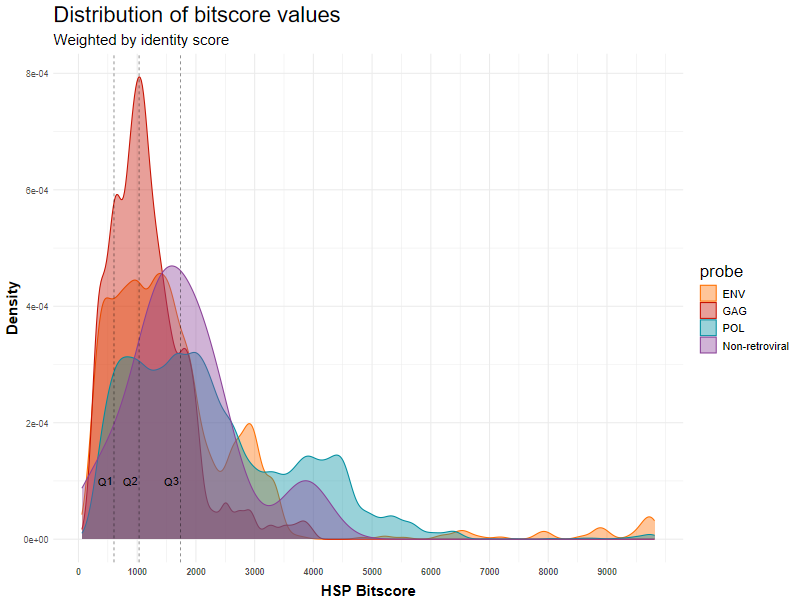

In [36]:
density.bitscore.plot <- data_nr %>%
    ggplot() +
      aes(
        x = hsp_bits,
        fill = probe,
        colour = probe,
        weight = hsp_identity,
      ) +
      geom_density(alpha = 0.4) +
      scale_fill_futurama() +
      scale_color_futurama() +
      labs(
        x = "HSP Bitscore",
        y = "Density",
        title = "Distribution of bitscore values",
        subtitle = "Weighted by identity score"
      ) +
      geom_vline(xintercept = c(q1_bit, median_bit, q3_bit), color = "black", linetype = "dashed", linewidth = 0.2) +
      annotate("text", x = q1_bit - 150, y = 1e-4, label = "Q1") +
      annotate("text", x = median_bit - 150, y = 1e-4, label = "Q2") +
      annotate("text", x = q3_bit - 150, y = 1e-4, label = "Q3") +
      scale_x_continuous(breaks = seq(0, max(data$hsp_bits), by = 1000)) +
      theme_minimal() +
      theme(
        plot.title = element_text(size = 22L),
        plot.subtitle = element_text(size = 15L),
        axis.title.y = element_text(size = 15L,
        face = "bold", vjust = 1),
        axis.title.x = element_text(size = 15L,
        face = "bold", vjust = -0.5),
        axis.text.x = element_text(face = "bold"),
        legend.text = element_text(size = 11L),
        legend.title = element_text(size = 17L)
      )

ggsave("../plots/density-bitscore.png", density.bitscore.plot, height = 15, width = 25)

density.bitscore.plot

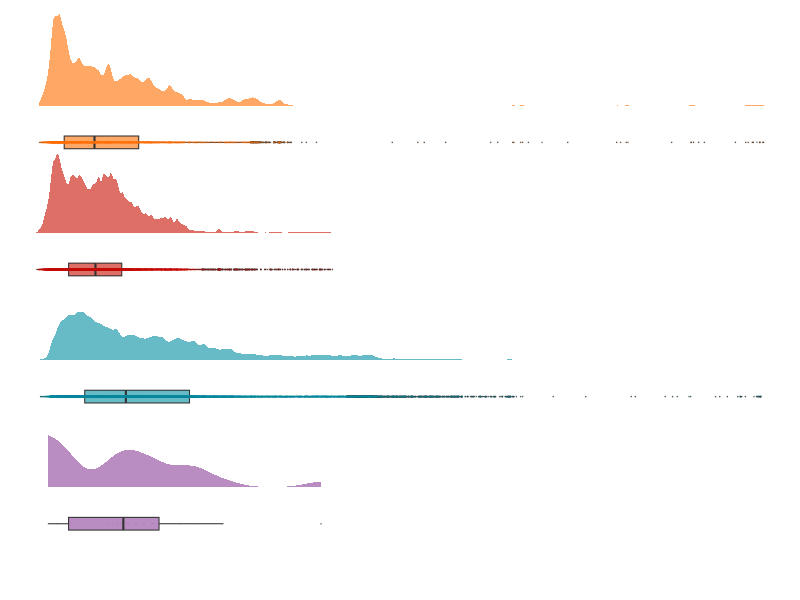

In [40]:
raincloud.bitscore.plot <- ggplot(data_nr, aes(x = factor(probe, rev(levels(probe))), y = hsp_bits)) +
                           geom_boxplot(aes(fill = probe), position = position_dodge(10), outlier.size = 0.001, width = 0.1, alpha = 0.6) +
                           geom_jitter(aes(color = probe), size = 0.05, width = 0.005, alpha = 0.1) +
                           stat_halfeye(aes(fill = probe), alpha = 0.6, adjust = 0.5, width = 0.8, .width = 0, justification = -0.4, point_interval = NULL) +
                           scale_fill_futurama() +
                           scale_color_futurama() +
                           coord_flip() +
                           theme_void() +
                           theme(legend.position = "None")

ggsave("../plots/raincloud-bitscore.png", raincloud.bitscore.plot, height = 15, width = 25)

raincloud.bitscore.plot

We are also going to get rid of rows without chromosome information:

In [16]:
data_chr <- data_nr %>%
            filter(!is.na(chromosome))

Let's take a look at the LTR and HSP sequence lengths:

We will add the HSP positions over the LTR candidates to zoom on the probe sequences, and generate new columns with it:

In [17]:
# Let's try generating artificial positions

data <- data %>%
        mutate(ltr_probe_start = ifelse(strand == "+", ltr_start + hsp_sbjct_start, ltr_start + hsp_sbjct_end),
               ltr_probe_end = ifelse(strand == "+", ltr_start + hsp_sbjct_end, ltr_start + hsp_sbjct_start))

In [18]:
gr <- GRanges(seqnames = factor(data$accession), 
              ranges = IRanges(
                start = data$ltr_probe_start,
                end = data$ltr_probe_end),
              strand = factor(data$strand))

mcols(gr)$family <- data$family
mcols(gr)$virus <- data$virus
mcols(gr)$bitscore <- data$hsp_bits
mcols(gr)$e_value <- format(data$hsp_evalue, scientific = TRUE)
mcols(gr)$species <- data$species
mcols(gr)$probe <- data$probe
mcols(gr)$accession <- data$accession
mcols(gr)$hsp_start <- data$hsp_sbjct_start
mcols(gr)$hsp_end <- data$hsp_sbjct_end

gr[322:333]

GRanges object with 12 ranges and 9 metadata columns:
         seqnames              ranges strand |          family
            <Rle>           <IRanges>  <Rle> |     <character>
   [1] CM040290.1   82139980-82140642      - | Spumaretrovirus
   [2] CM040300.1   46271780-46272512      + | Gammaretrovirus
   [3] CM040300.1   47782717-47789968      - | Gammaretrovirus
   [4] CM040300.1   46271775-46272512      - | Gammaretrovirus
   [5] CM040290.1   82140650-82142684      + | Gammaretrovirus
   ...        ...                 ...    ... .             ...
   [8] CM040290.1   97093065-97093911      + | Gammaretrovirus
   [9] CM040293.1 150720751-150727220      + | Gammaretrovirus
  [10] CM040300.1     7878896-7879736      + |  Betaretrovirus
  [11] CM040294.1   13868418-13872303      + | Spumaretrovirus
  [12] CM040295.1   52225857-52228598      + | Spumaretrovirus
                        virus  bitscore      e_value           species
                  <character> <numeric>  <character>    

Let's select a single species to compare against RetroTector. First let's see how many rows does each species contain:

In [19]:
species_unique_count <- data %>%
                        group_by(species) %>%
                        summarise(species_count = length(species))

species_unique_count

# A tibble: 25 × 2
   species                  species_count
   <chr>                            <int>
 1 Antrozous_pallidus                1779
 2 Artibeus_lituratus                1600
 3 Corynorhinus_townsendii           1460
 4 Desmodus_rotundus                 1003
 5 Eptesicus_fuscus                  1726
 6 Eptesicus_nilssonii               2295
 7 Glossophaga_mutica                1214
 8 Hipposideros_larvatus             1070
 9 Miniopterus_schreibersii           780
10 Molossus_alvarezi                 2687
# ℹ 15 more rows
# ℹ Use `print(n = ...)` to see more rows

We will go with Hipposideros larvatus. Let's filter the GRanges object for only that species and order the findings by position.

In [20]:
gr_hl <- gr[gr$species == 'Hipposideros_larvatus']

un_gr_hl <- unique(gr_hl)

un_gr_hl


GRanges object with 972 ranges and 9 metadata columns:
          seqnames              ranges strand |          family
             <Rle>           <IRanges>  <Rle> |     <character>
    [1] CM063091.1 169589024-169589294      - |  Betaretrovirus
    [2] CM063092.1 160255942-160263510      + |  Betaretrovirus
    [3] CM063105.1   64122340-64133048      - |  Betaretrovirus
    [4] CM063088.1 113305840-113307473      - |  Betaretrovirus
    [5] CM063094.1   62351309-62353060      - |  Betaretrovirus
    ...        ...                 ...    ... .             ...
  [968] CM063102.1   34265954-34271623      - | Spumaretrovirus
  [969] CM063096.1   61203641-61210768      + | Spumaretrovirus
  [970] CM063089.1     2110664-2113141      + |  Betaretrovirus
  [971] CM063092.1   81051698-81052284      + | Spumaretrovirus
  [972] CM063103.1   37204168-37208022      - |  Betaretrovirus
                         virus  bitscore      e_value               species
                   <character> <numer

We can generate GFF3 files from this range

In [21]:
export(un_gr_hl, "F:/Archive/Trabajo/Profesiones/Bioinformatica/PhD/Assignments/enERVate/results/tracks/gr_hl_unique.gff", "GFF3")

Let's also try with Molossus nigricans.

In [22]:
gr_mn <- gr[gr$species == 'Molossus_nigricans']

un_gr_mn <- unique(gr_mn)

mcols(un_gr_mn)$Name <- paste0(un_gr_mn$probe, ":", ave(seq_along(un_gr_mn$probe), un_gr_mn$probe, FUN = seq_along))

un_gr_mn

GRanges object with 3393 ranges and 10 metadata columns:
                  seqnames            ranges strand |          family
                     <Rle>         <IRanges>  <Rle> |     <character>
     [1]        CM078089.1 72684089-72685681      + |      Lentivirus
     [2]        CM078076.1 33938773-33942969      - |      Lentivirus
     [3]        CM078076.1   2717211-2718405      - |      Lentivirus
     [4]        CM078089.1 89689258-89690273      + |      Lentivirus
     [5]        CM078089.1 67053124-67053711      + |      Lentivirus
     ...               ...               ...    ... .             ...
  [3389] JBDPII010000027.1   2793683-2795439      - | Spumaretrovirus
  [3390] JBDPII010000089.1     310447-312586      - | Spumaretrovirus
  [3391] JBDPII010000032.1       43957-46884      - | Spumaretrovirus
  [3392] JBDPII010000068.1     471708-473638      + | Spumaretrovirus
  [3393]        CM078089.1 14535339-14540335      - | Spumaretrovirus
                          virus  

In [23]:
export(un_gr_mn, "F:/Archive/Trabajo/Profesiones/Bioinformatica/PhD/Assignments/enERVate/results/tracks/gr_mn_unique.gff", "GFF3")

Let's generate some Sankey diagrams:

In [33]:
data_counted_probe <- data_nr %>%
                      # filter(probe %in% c('ENV', 'POL', 'GAG')) %>%
                      mutate(species = stringr::str_replace(species, "_", " ")) %>%
                      group_by(species, virus, probe, family, abbreviation) %>%
                      summarise(count = n()) %>%
                      ungroup()


sum(data_counted_probe[data_counted_probe$probe == "Non-retroviral", ]$count)

`summarise()` has grouped output by 'species', 'virus', 'probe', 'family'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'species', 'virus', 'probe', 'family'. You can override using the `.groups` argument.


[1] 26

Warning message:
The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


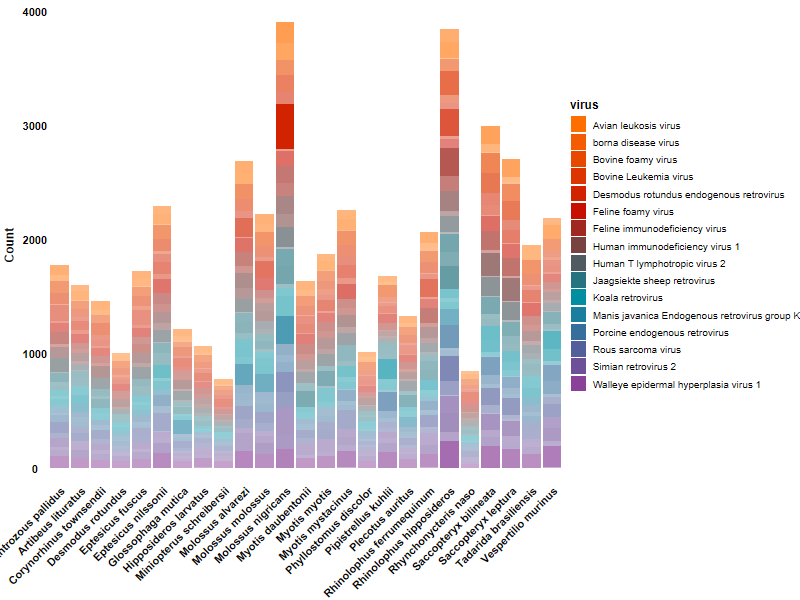

In [25]:
bar.species_virus.plot <- ggplot(data_counted_probe) +
  aes(
    x = species,
    y = count,
    fill = (virus),
    alpha = count
  ) +
  geom_col() +
  scale_fill_manual(values = futurama_unlimited_palette(4, 16)) +
  scale_alpha_continuous(range = c(0.4, 1)) +
  # scale_fill_futurama() +
  theme_void() +
  labs(fill = "virus",
       x = NULL,
       y = "Count",
  ) +
    theme(
        axis.title.x = element_text(size = 12, face = "bold"),     # X-axis title size and bold
        axis.title.y = element_text(size = 12, face = "bold", angle = 90, vjust = 3, margin = margin(l = 10)),     # Y-axis title size and bold
        axis.text.x = element_text(size = 11, face = "bold", angle = 45, vjust = 1, hjust = 1, margin = margin(t = -5)),    # X-axis text size and italic
        axis.text.y = element_text(size = 11, face = "bold"),                     # Y-axis text size (regular)
        strip.text = element_text(size = 12, face = "bold"),       # Facet labels (strip text) size and bold
        legend.title = element_text(size = 12, face = "bold"),     # Legend title size and bold
        legend.text = element_text(size = 10)                     # Legend text size (regular)
      ) +
    guides(alpha = FALSE)

ggsave("../plots/bar_species_virus_plot.png", bar.species_virus.plot, height = 15, width = 25)

bar.species_virus.plot  

In [57]:
data_counted_probe_2n <- data_counted_probe %>% 
  group_by(family, probe) %>% 
  arrange(probe, desc(count)) %>% 
  slice_head(n = 2)

data_counted_probe_2n

# A tibble: 38 × 6
# Groups:   family, probe [19]
   species                   virus                       probe family          abbreviation count
   <chr>                     <fct>                       <fct> <fct>           <chr>        <int>
 1 Rhinolophus ferrumequinum Rous sarcoma virus          ENV   Alpharetrovirus RSV             31
 2 Phyllostomus discolor     Avian leukosis virus        ENV   Alpharetrovirus ALV             30
 3 Molossus nigricans        Avian leukosis virus        GAG   Alpharetrovirus ALV            146
 4 Rhinolophus hipposideros  Avian leukosis virus        GAG   Alpharetrovirus ALV            140
 5 Rhinolophus hipposideros  Rous sarcoma virus          POL   Alpharetrovirus RSV            221
 6 Molossus nigricans        Avian leukosis virus        POL   Alpharetrovirus ALV            185
 7 Rhinolophus hipposideros  Jaagsiekte sheep retrovirus ENV   Betaretrovirus  JSRV           202
 8 Myotis daubentonii        Jaagsiekte sheep retrovirus ENV   Betar

In [62]:
esquisse::esquisser()

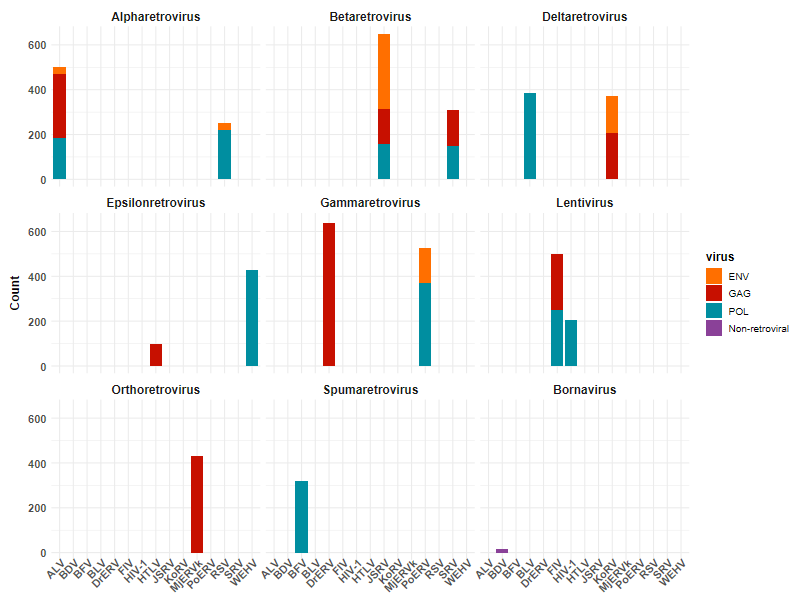

In [60]:
bar.family_probe.plot <- ggplot(data_counted_probe_2n) +
  aes(
    x = abbreviation,
    y = count,
    fill = probe,
    # alpha = count
  ) +
  geom_col() +
  # scale_fill_manual(values = futurama_unlimited_palette(4, length(unique(data_counted_probe$virus)))) +
  scale_alpha_continuous(range = c(0.4, 1)) +
  scale_fill_futurama() +
  theme_minimal() +
  labs(fill = "virus",
       x = NULL,
       y = "Count",
  ) +
    theme(
        axis.title.x = element_text(size = 12, face = "bold"),     # X-axis title size and bold
        axis.title.y = element_text(size = 12, face = "bold", angle = 90, vjust = 3, margin = margin(l = 10)),     # Y-axis title size and bold
        axis.text.x = element_text(size = 11, face = "bold", angle = 45, vjust = 1, hjust = 1, margin = margin(t = -5)),    # X-axis text size and italic
        axis.text.y = element_text(size = 11, face = "bold"),                     # Y-axis text size (regular)
        strip.text = element_text(size = 12, face = "bold"),       # Facet labels (strip text) size and bold
        legend.title = element_text(size = 12, face = "bold"),     # Legend title size and bold
        legend.text = element_text(size = 10)                     # Legend text size (regular)
      ) +
    guides(alpha = FALSE) +
    facet_wrap(~family)

ggsave("../plots/bar_family_probe_plot.png", bar.family_probe.plot, height = 15, width = 25)

bar.family_probe.plot  

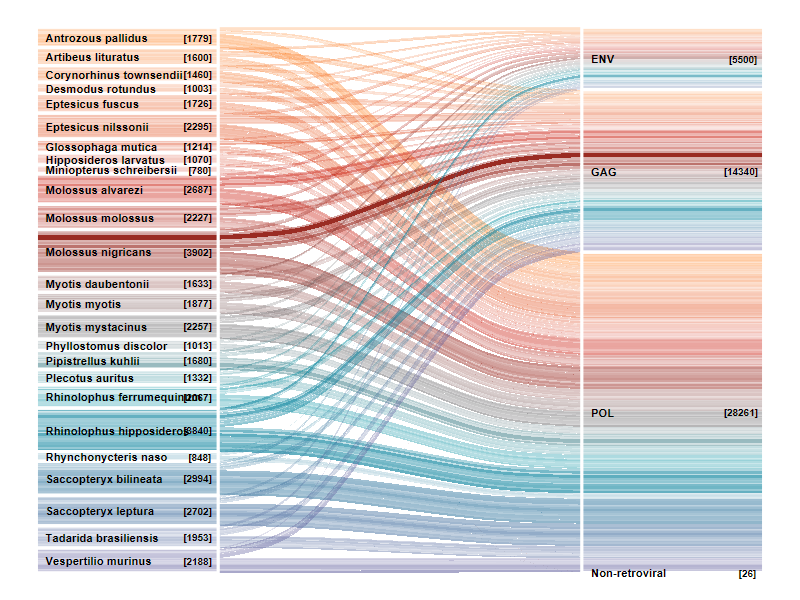

In [27]:
sankey.species_probe.plot <- ggplot(data_counted_probe, aes(axis1 = species, axis2 = probe, y = count)) +
                      geom_alluvium(aes(fill = species, alpha = count)) +
                      geom_stratum(alpha = 0, color = "white", linewidth = 1.5) +
                      geom_text(stat = 'stratum', aes(label = after_stat(stratum)), size = 4L, fontface = "bold", nudge_x = -0.15, hjust = 0) +
                      geom_text(aes(label = paste0("[", after_stat(count), "]")), size = 3.5, fontface = "bold", nudge_x = 0.15, hjust = 0.9, stat = "stratum") +
                      theme_void() +
                      theme(legend.position = "none") +
                      scale_fill_manual(values = futurama_unlimited_palette(12, 100))

ggsave("../plots/sankey-species_probe.png", sankey.species_probe.plot, width = 25, height = 15)

sankey.species_probe.plot

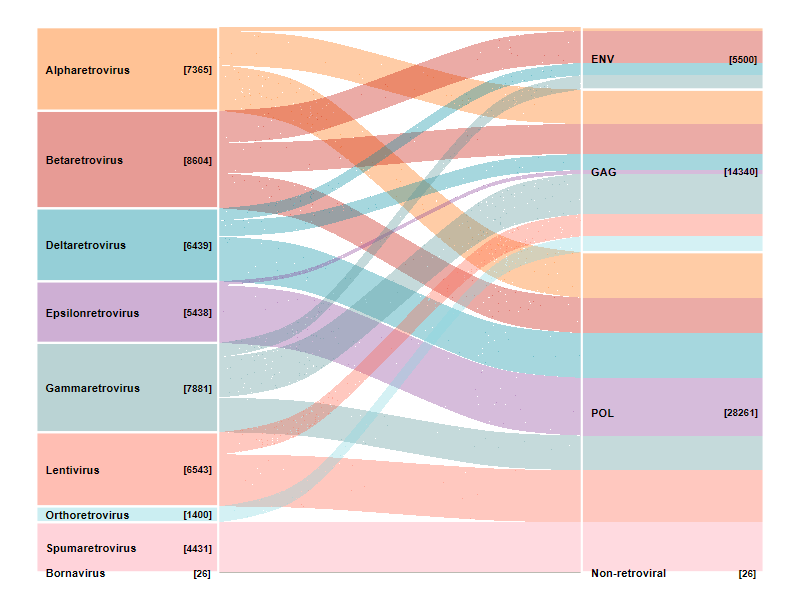

In [28]:
sankey.family_probe.plot <- ggplot(data_counted_probe, aes(axis1 = family, axis2 = probe, y = count)) +
                    geom_alluvium(aes(fill = family)) +
                    geom_stratum(aes(fill = family), color = "white", alpha = 0.1, linewidth = 1) +
                    geom_text(stat = 'stratum', aes(label = after_stat(stratum)), size = 4L, fontface = "bold", nudge_x = -0.15, hjust = 0) +
                    geom_text(stat = "stratum", aes(label = paste0("[", after_stat(count), "]")), size = 3.5, fontface = "bold", nudge_x = 0.15, hjust = 0.9) +
                    theme_void() +
                    theme(legend.position = "none") +
                    scale_fill_futurama(alpha = 0.7)


ggsave("../plots/sankey-probe_family.png", sankey.family_probe.plot, width = 25, height = 15)

sankey.family_probe.plot

And together...

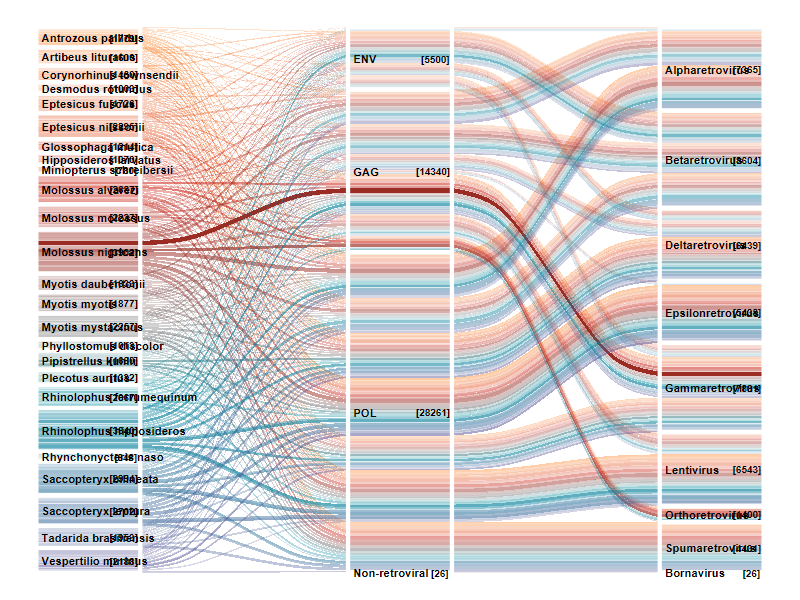

In [29]:
sankey.species_probe_family.plot <- ggplot(data_counted_probe, aes(axis1 = species, axis2 = probe, axis3 = family, y = count)) +
                      geom_alluvium(aes(fill = species, alpha = count)) +
                      geom_stratum(alpha = 0, color = "white", linewidth = 2) +
                      geom_text(stat = 'stratum', aes(label = after_stat(stratum)), size = 4L, fontface = "bold", nudge_x = -0.15, hjust = 0) +
                      geom_text(stat = "stratum", aes(label = paste0("[", after_stat(count), "]")), size = 3.5, fontface = "bold", nudge_x = 0.15, hjust = 0.9) +                      theme_void() +
                      theme(legend.position = "none") +
                      scale_fill_manual(values = futurama_unlimited_palette(12, 100))

ggsave("sankey-species_probe_family.png", sankey.species_probe_family.plot, width = 25, height = 15)

sankey.species_probe_family.plot

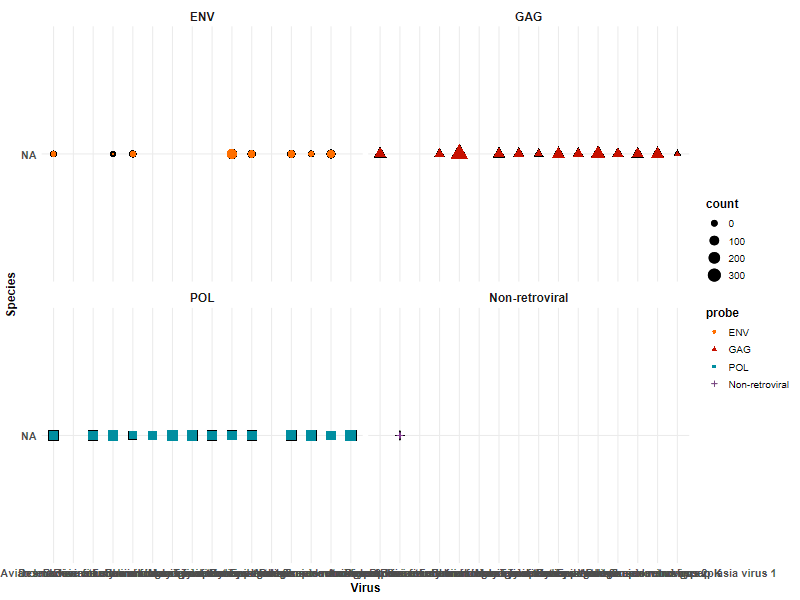

In [35]:
balloon.virus_species.plot <- ggplot(data_counted_probe, aes(x = virus, y = factor(species, levels = rev(levels(species))))) +
                              geom_point(aes(shape = probe, size = count), color = "black") +
                              geom_point(aes(color = probe, shape = probe, size = count-40)) +
                              scale_color_futurama() +
                              facet_wrap(~ probe) +
                              theme_minimal() +
                              labs(
                                x = "Virus",
                                y = "Species"
                              ) +
                              theme(
                                  axis.title.x = element_text(size = 12, face = "bold"),     # X-axis title size and bold
                                  axis.title.y = element_text(size = 12, face = "bold"),     # Y-axis title size and bold
                                  axis.text.x = element_text(size = 11, face = "bold"),    # X-axis text size and italic
                                  axis.text.y = element_text(size = 11, face = "bold"),                     # Y-axis text size (regular)
                                  strip.text = element_text(size = 12, face = "bold"),       # Facet labels (strip text) size and bold
                                  legend.title = element_text(size = 12, face = "bold"),     # Legend title size and bold
                                  legend.text = element_text(size = 10)                     # Legend text size (regular)
                                )

ggsave("../plots/balloon-virus_species_plot.png", balloon.virus_species.plot, width = 25, height = 15)

balloon.virus_species.plot

In [31]:
getwd()

[1] "F:/Archive/Trabajo/Profesiones/Bioinformatica/PhD/Assignments/enERVate/results/analysis"